# Classificação - Português

Este notebook realiza a modelagem preditiva da aprovação estudantil na disciplina de **Português**, com base em atributos contextuais e de desempenho. A análise inclui:
- Preparação dos dados
- Avaliação de classificadores binários
- Comparação com e sem balanceamento
- Otimização de hiperparâmetros

**Base:** Student Performance Dataset (UCI)  
**Target:** variável `aprovacao` (0 = Reprovado, 1 = Aprovado)

###### ajustar o path

In [1]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

# 1. Importação e setup

In [2]:
#Importação dos Módulos e Funções Desenvolvidos

from pre_modelagem import *
from modelagem import *
# Importação de bibliotecas padrão
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

materia = 'portugues'
df_raw = importar_base(materia)
df_modelo = preparar_dados(df_raw, scaling=True,columns_to_drop=['nota1','nota2','nota_final'])

X = df_modelo.drop(columns='aprovacao').values
y = df_modelo['aprovacao'].values


# Configurações do Pandas para exibir todas as linhas e colunas no DataFrame 
# para inspeção detalhada dos dados no Jupyter Notebook

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')

Removendo colunas: ['nota1', 'nota2', 'nota_final']
Aplicando Imputação(mean) e Scaling(StandardScaler) a: ['idade', 'escolaridade_mae', 'escolaridade_pai', 'tempo_transporte', 'tempo_estudo', 'reprovacoes', 'relacao_familiar', 'tempo_livre', 'frequencia_saidas', 'alcool_dias_uteis', 'alcool_fim_semana', 'saude', 'faltas']
Shape final do DataFrame preparado: (649, 40)


# Avaliação dos modelos
## Subseção 2.1 - Modelos considerados
- Regressão Logística
- Árvore de Decisão
- Random Forest
- SVM (com probabilidade)
- Gradient Boosting (substituindo AdaBoost)

Avaliamos os modelos com **validação cruzada** e também com **balanceamento SMOTE-Tomek** nos dados de treino.

In [3]:
# === Classificadores base ===
classificadores = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# === Dicionário de hiperparâmetros para otimização ===
param_spaces = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "liblinear",'saga','l1','l2'],
        "penalty": ["l1","l2"]
    },
    "DecisionTree": {
        "max_depth": [2, 3, 5, 10, None],
        "min_samples_split": [2, 5, 10, 15],
        'min_samples_leaf': [1, 3, 5],
        "criterion": ["gini", "entropy"],
        
    },
    "RandomForest": {
        "n_estimators": [50, 100, 200,300],
        "max_depth": [5, 10, None],
        "max_features": ["sqrt", "log2"],
        'min_samples_split': [2, 5, 10,15],
        'min_samples_leaf': [1, 3, 5]
    },
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [2, 3, 5],
        'subsample': [0.8, 1.0],
        'min_samples_leaf': [1, 3, 5]
    },
    "SVM": {
        "C": [0.01 ,0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto", 0.1, 0.01, 0.001]
    }
}



# 3.  Comparação de desempenho
## 3.1. Visualização dos rankings por métrica
Inclui: Acurácia, F1-Score, AUC-ROC e outras métricas para os dois cenários:
- Dados originais
- Dados balanceados


Processando modelo: Logistic Regression
  Avaliando Logistic Regression (sem otimização)...
  Otimizando Logistic Regression com GridSearchCV...
    Melhores Parâmetros: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
  Gerando matrizes de confusão comparativas...
Figura salva em: imagens\matrizes_confusao\matriz_confusao_Logistic Regression_portugues.png.png


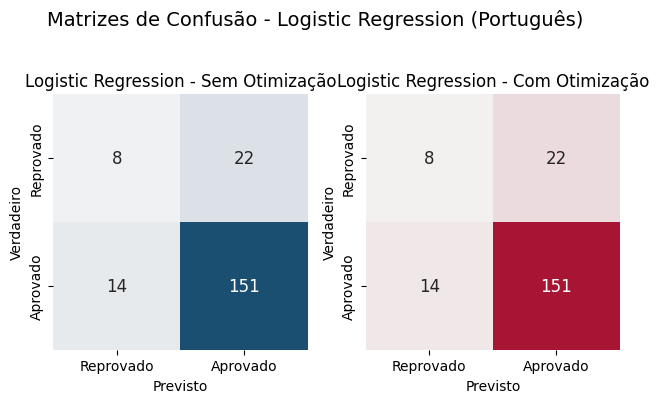

  Gerando curvas ROC e PR comparativas...
Figura salva em: imagens\curvas_comparativas_models\curvas_roc_pr_Logistic Regression_portugues.png_portugues.png


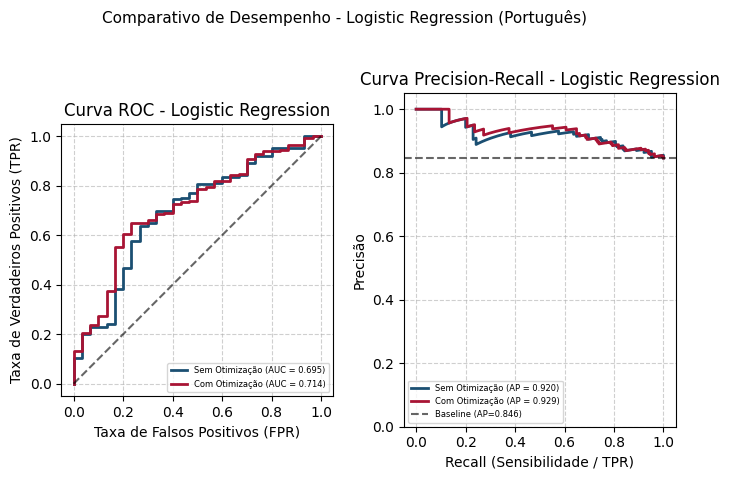


Processando modelo: DecisionTree
  Avaliando DecisionTree (sem otimização)...
  Otimizando DecisionTree com GridSearchCV...
    Melhores Parâmetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}
  Gerando matrizes de confusão comparativas...
Figura salva em: imagens\matrizes_confusao\matriz_confusao_DecisionTree_portugues.png.png


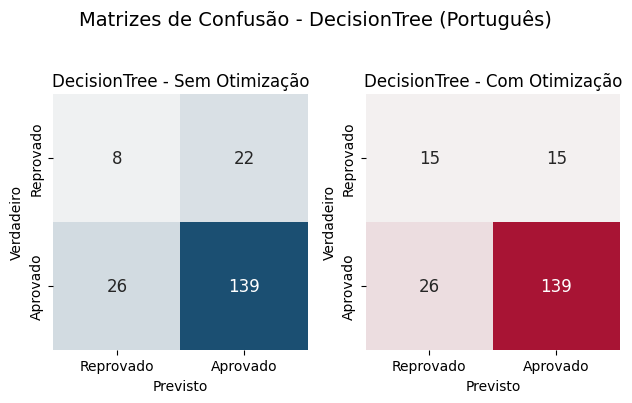

  Gerando curvas ROC e PR comparativas...
Figura salva em: imagens\curvas_comparativas_models\curvas_roc_pr_DecisionTree_portugues.png_portugues.png


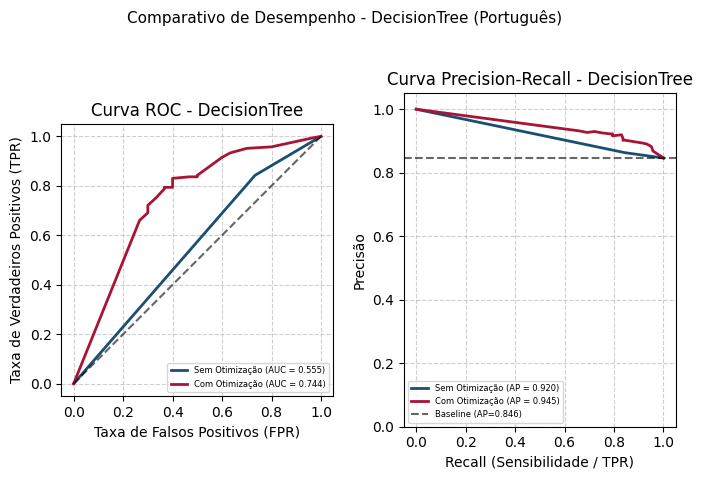


Processando modelo: RandomForest
  Avaliando RandomForest (sem otimização)...
  Otimizando RandomForest com GridSearchCV...


In [ ]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_spaces
)
print('\n\n \n \n Conjunto de Treino Balanceado\n \n \n \n\n')
# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_spaces
)

In [ ]:
display(df_resultados)

display(df_cv)

display(verificar_overfitting(df_resultados, df_cv))

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

In [ ]:
display(df_resultados_bal)

display(df_cv_bal)

display(verificar_overfitting(df_resultados_bal, df_cv_bal))


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=[metric],        
                                            materia=materia  
                                         )     

# 4 . Modelagem 1: Seleção Baseada em Critérios Estatísticos e Relevância Direta

**Objetivos:**
- Foco na escolha de atributos que demonstram uma relação estatisticamente significativa com a variável alvo ('aprovacao')
- multicolinearidade critério de alta relevância.

## 4.1 **METODOLOGIA DA SELEÇÃO DOS ATRIBUTOS**

### Seleção Categórica (Qui-Quadrado): Utilizar o teste Qui-Quadrado χ 

- avaliar a associação entre cada variável categórica (nominal ou binária, após one-hot encoding) e a variável 'aprovacao'. 
Selecionar apenas as variáveis com valor-p < 0.05 (ou um limiar similar).


In [ ]:
variaveis_dummies_chi2 = [
    'escola_Mousinho da Silveira',
    'motivo_escolha_escola_Reputação da escola',
    'interesse_ensino_superior',
    'profissao_mae_Professor(a)',
    'motivo_escolha_escola_Outro motivo'
]


### Seleção Quantitativa/Ordinal (Correlação/Significância):

- Calcular a correlação (ex: Spearman) entre as variáveis quantitativas/ordinais e a variável 'aprovacao'. 
Selecionar aquelas com correlação significativa (considerando um limiar de valor absoluto e/ou valor-p).


In [ ]:
variaveis_ordinais_relevantes = [
    'tempo_estudo', 'reprovacoes', 'tempo_livre',
    'frequencia_saidas', 'alcool_fim_semana', 'saude', 'faltas'
]



### Tratamento de Multicolinearidade (VIF/Correlação):
- variáveis com alta correlação (>0.6) e VIF > 5 identificados: (escolaridade_mae/pai, alcool_dias_uteis/fim_semana).
- Foram escolhidos para serem removidos: escolaridade_pai e alcool_fim_semana


In [ ]:

variaveis_alta_colineariedade = [
            'escolaridade_mae',
            #'escolaridade_pai',
            'alcool_fim_semana',
            #'alcool_dias_uteis',
            #'profissao_pai_Outra profissão',
            #'profissao_pai_Serviços'
        ]


In [ ]:
selecao = variaveis_ordinais_relevantes + variaveis_dummies_chi2+variaveis_alta_colineariedade

In [ ]:
df_corr_dummies = df_modelo[selecao].corr()
df_corr_dummies.T


In [ ]:
selecao.remove('frequencia_saidas')

In [ ]:
variaveis_final = sorted(selecao)
X = df_modelo[variaveis_final]
y = df_modelo['aprovacao']

In [ ]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_spaces
)
print('\n\n \n \n Conjunto de Treino Balanceado\n \n \n \n\n')
# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_spaces
)

In [ ]:
display(df_resultados)

display(df_cv)

display(verificar_overfitting(df_resultados, df_cv))

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

In [ ]:
display(df_resultados_bal)

display(df_cv_bal)

display(verificar_overfitting(df_resultados_bal, df_cv_bal))


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=[metric],        
                                            materia=materia  
                                         )     

# 5. Modelagem 2: Seleção Baseada em Impacto Observado na EDA e Relevância Contextual



In [ ]:
variaveis_mais_significativas = [
    'reprovacoes',
    'escolaridade_mae',
    'tempo_estudo',
    'interesse_ensino_superior',
    'escolaridade_pai',
    'alcool_dias_uteis',
    'escola_Mousinho da Silveira',
    'interesse_ensino_superior',
    'tempo_estudo',
    'faltas'  # variável secundária
]




In [ ]:
X = df_modelo[variaveis_mais_significativas]
y = df_modelo['aprovacao']

In [ ]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_spaces
)
print('\n\n \n \n Conjunto de Treino Balanceado\n \n \n \n\n')
# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_spaces
)

In [ ]:
display(df_resultados)

display(df_cv)

display(verificar_overfitting(df_resultados, df_cv))

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

In [ ]:
display(df_resultados_bal)

display(df_cv_bal)

display(verificar_overfitting(df_resultados_bal, df_cv_bal))


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=[metric],        
                                            materia=materia  
                                         )     

## 6. Modelagem 3 - Definida a partir de relatórios de Regressão

In [ ]:
variaveis_relevantes = ['reprovacoes',
 'escola_Mousinho da Silveira',
 'interesse_ensino_superior',
 'apoio_escolar',
 'tempo_estudo',
 'saude',
 'alcool_dias_uteis',
 'genero_Mulher',
 'profissao_pai_Professor(a)',
 'relacionamento_romantico',
 'idade',
 'motivo_escolha_escola_Outro motivo',
 'escolaridade_pai',
 'faltas',
 'profissao_mae_Área da saúde',
 'acesso_internet']




In [ ]:
X = df_modelo[variaveis_relevantes]
y = df_modelo['aprovacao']

In [ ]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_spaces
)
print('\n\n \n \n Conjunto de Treino Balanceado\n \n \n \n\n')
# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_spaces
)

In [ ]:
display(df_resultados)

display(df_cv)

display(verificar_overfitting(df_resultados, df_cv))

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

In [ ]:
display(df_resultados_bal)

display(df_cv_bal)

display(verificar_overfitting(df_resultados_bal, df_cv_bal))


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=[metric],        
                                            materia=materia  
                                         )     